In [1]:
%load_ext autoreload
%autoreload 2

from classification_models.tfkeras import Classifiers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.enable_eager_execution()

keras = tf.keras
K = tf.keras.backend

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import iic_datasets_ops
import iic_loss_ops
import utils
import models

In [57]:
batch_size = 256
image_size = 28
num_classes = 10
num_repeats = 5
input_shape = (24, 24, 1)
num_train_steps = 60000 // batch_size
num_eval_steps = 10000 // batch_size

In [58]:
train_dataset, dataset_info = tfds.load(name="mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST, as_supervised=True)

In [59]:
train_dataset

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [60]:
iic_train_dataset = iic_datasets_ops.prepare_training_dataset(train_dataset, num_image_repeats=num_repeats)

Tensor("stack_15:0", shape=(5, 24, 24, 1), dtype=float32)


In [61]:
iic_train_iterator = iic_train_dataset.make_one_shot_iterator()

In [64]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 35.44 times longer than the fastest. This could mean that an intermediate result is being cached.
8.68 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


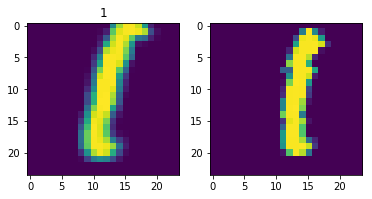

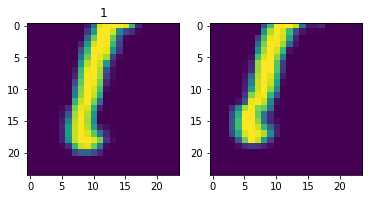

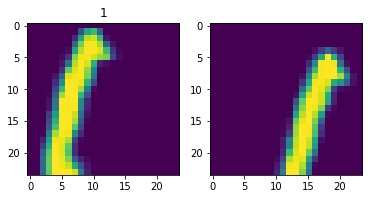

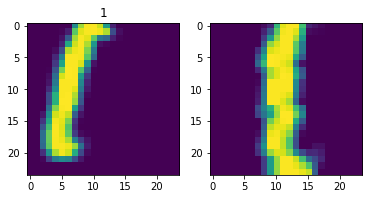

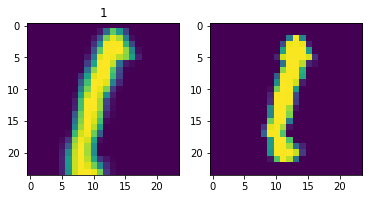

In [65]:
utils.plot_image_pairs(*next(iic_train_iterator), num_examples=5)

In [66]:
base_model = models.create_resnet_se_backbone(input_shape, (1, 1), attention=None)

In [67]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 24, 24, 1)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 24, 24, 1)    3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 30, 30, 1)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 12, 12, 64)   3136        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [85]:
inputs, main_heads, aux_heads = models.create_iic_model(
    input_shape, base_model, 
    main_head_num_classes=num_classes, 
    aux_head_num_classes=5 * num_classes,
    num_main_heads=5,
    num_aux_heads=1
)

In [86]:
inputs, main_heads, aux_heads

({'image': <tf.Tensor 'image_1:0' shape=(?, 24, 24, 1) dtype=float32>,
  'tf_image': <tf.Tensor 'tf_image_1:0' shape=(?, 24, 24, 1) dtype=float32>},
 [{'outputs': [<tf.Tensor 'main_head_0/p_out_1/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_0/p_tf_out_1/Identity:0' shape=(?, 10) dtype=float32>],
   'loss': <tf.Tensor 'main_head_0/iic_loss_1:0' shape=() dtype=float32>},
  {'outputs': [<tf.Tensor 'main_head_1/p_out/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_1/p_tf_out/Identity:0' shape=(?, 10) dtype=float32>],
   'loss': <tf.Tensor 'main_head_1/iic_loss:0' shape=() dtype=float32>},
  {'outputs': [<tf.Tensor 'main_head_2/p_out/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_2/p_tf_out/Identity:0' shape=(?, 10) dtype=float32>],
   'loss': <tf.Tensor 'main_head_2/iic_loss:0' shape=() dtype=float32>},
  {'outputs': [<tf.Tensor 'main_head_3/p_out/Identity:0' shape=(?, 10) dtype=float32>,
    <tf.Tensor 'main_head_3/p_tf_out/I

In [87]:
heads_p_out = [head['outputs'][0] for head in main_heads]
iic_main_model = keras.Model(inputs=inputs, outputs=[heads_p_out])

heads_p_out = [head['outputs'][0] for head in aux_heads]
iic_aux_model = keras.Model(inputs=inputs, outputs=[heads_p_out])

In [88]:
main_heads_loss = tf.add_n([head['loss'] for head in main_heads]) / len(main_heads)
aux_heads_loss = tf.add_n([head['loss'] for head in aux_heads]) / len(aux_heads)
main_heads_loss, aux_heads_loss

(<tf.Tensor 'truediv_18:0' shape=() dtype=float32>,
 <tf.Tensor 'truediv_19:0' shape=() dtype=float32>)

In [89]:
iic_main_model.add_loss(main_heads_loss)
iic_aux_model.add_loss(aux_heads_loss)

In [90]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_main_model.compile(optimizer=optimizer)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_aux_model.compile(optimizer=optimizer)

In [91]:
iic_main_model.outputs

[<tf.Tensor 'main_head_0/p_out_1/Identity:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'main_head_1/p_out/Identity:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'main_head_2/p_out/Identity:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'main_head_3/p_out/Identity:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'main_head_4/p_out/Identity:0' shape=(?, 10) dtype=float32>]

In [ ]:
# for epoch in range(10):
#     print(epoch)
#     iic_main_model.fit(
#         iic_train_iterator, verbose=1, epochs=1,
#         steps_per_epoch=num_train_steps, callbacks = [utils.PredictionsHistory(iic_train_iterator)]
#     )
# #     iic_aux_model.fit(
# #         iic_train_iterator, verbose=1, epochs=1,
# #         steps_per_epoch=num_train_steps
# #     )

In [ ]:
for epoch in range(20):
    print(epoch)
    iic_main_model.fit(
        iic_train_iterator, verbose=1, epochs=1,
        steps_per_epoch=num_train_steps, callbacks = [utils.PredictionsHistory(iic_train_iterator)]
    )
    iic_aux_model.fit(
        iic_train_iterator, verbose=1, epochs=1,
        steps_per_epoch=num_train_steps
    )

0
  1/234 [..............................] - ETA: 5:08:03 - loss: -0.1327WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.490231). Check your callbacks.


234/234 [==============================] - 38s 163ms/step - loss: -1.2924
1
234/234 [==============================] - 12s 53ms/step - loss: -1.8256
2
234/234 [==============================] - 12s 52ms/step - loss: -1.8936
3
 73/234 [========>.....................] - ETA: 21s - loss: -1.5219

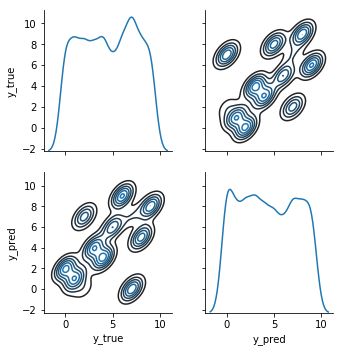

In [84]:
utils.plot_probabilities_grid(iic_main_model, iic_train_iterator)